In [10]:
import os

# Set environment variables to disable multithreading as users will probably
# want to set the number of cores to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
###############################################################################
# Set TensorFlow print of log information
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [11]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from anomaly.constants import GALAXY_LINES
from autoencoders.ae import AutoEncoder
from sdss.metadata import MetaData
from anomaly.utils import specobjid_to_idx
from astroExplain.spectra.notebook import interpret, explain_reconstruction_score

meta = MetaData()
%matplotlib inline

In [12]:
# def interpret(specobjid, data_directory, wave, npos=5, nneg=5, pkl=True, explanation=None):
#     """Visualize interpretability"""

#     if pkl is True:
        
#         with open(f"{data_directory}/{specobjid}.pkl", "rb") as file:

#             explanation = pickle.load(file)
    
#     why = TellMeWhy(wave=wave, explanation=explanation)
#     fig, axs = why.plot_full_explanation()

#     _, positive_spectrum = why.positive_mask_and_segments(npos)
#     _, negative_spectrum = why.negative_mask_and_segments(nneg)
#     weights_explanation = why.get_heatmap()
#     # weights_explanation = why.smooth_and_normalize_explanation(False, 0.)
#     for ax in axs: ax.clear()

#     axs[0].plot(why.wave, why.galaxy, c="black")
#     axs[0].plot(why.wave, positive_spectrum, c="red")
#     axs[0].plot(why.wave, negative_spectrum, c="blue")

#     max_weight = np.nanmax(np.abs(weights_explanation))
#     max_weight += 0.1*max_weight
#     axs[1].set_ylim(ymin=-max_weight, ymax=max_weight)

#     axs[1].plot(why.wave, weights_explanation)
#     axs[1].hlines(0, xmin=wave.min(), xmax=wave.max(), color="black")

#     return fig, axs

# def explain_score(
#     wave:np.array, spectrum: np.array,
#     score_configuration: dict, lime_configuration: dict, fudge_configuration: dict,
#     model,
# ):

#     anomaly = ReconstructionAnomalyScore(
#         # reconstruct_function
#         model.reconstruct,
#         filter_parameters=FilterParameters(
#             wave=wave,
#             lines=score_configuration["lines"],
#             velocity_filter=score_configuration["velocity"]
#         ),
#         reconstruction_parameters=ReconstructionParameters(
#             percentage=score_configuration["percentage"],
#             relative=score_configuration["relative"],
#             epsilon=score_configuration["epsilon"]
#         )
#     )

#     anomaly_score_function = partial(
#         anomaly.score, metric=score_configuration["metric"]
#     )
#     # Set explainer instance
#     print(f"Set explainer and Get explanations", end="\n")
#     explainer = LimeSpectraExplainer(random_state=0)

#     if lime_configuration["segmentation"] == "kmeans":
        
#         segmentation_fn = SpectraSegmentation().kmeans

#     elif lime_configuration["segmentation"] == "uniform":

#         segmentation_fn = SpectraSegmentation().uniform


    # segmentation_fn = partial(
    #     segmentation_fn, number_segments=lime_configuration["number_segments"]
    # )
    # # Load galaxy
    # # Compute anomaly score
    # # convert spectrum to gray image
    # spectrum = spectrum[np.newaxis, :]
    # # Get explanations
    # explanation = explainer.explain_instance(
    #     spectrum=spectrum,
    #     classifier_fn=anomaly_score_function,
    #     segmentation_fn=segmentation_fn,
    #     fudge_parameters = fudge_configuration,
    #     explainer_parameters = lime_configuration,
    # )

    # return explanation

In [13]:
# config
bin_id = "bin_04"
model_id = "0013"
architecture = "256_128_64/latent_12"
meta_data_directory = "/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf"
model_directory = f"{meta_data_directory}/{bin_id}/models/{architecture}/{model_id}"
explanations_directory = f"{meta_data_directory}/{bin_id}/explanation/{architecture}"

In [14]:
# load data
wave = np.load(f"{meta_data_directory}/wave.npy")
meta_data_df = pd.read_csv(f"{meta_data_directory}/0_01_z_0_5_4_0_snr_inf.csv.gz", index_col="specobjid")
model = AutoEncoder(reload=True, reload_from=model_directory)

## Explore common anomalies of different scores

### $L^p$ scores

In [17]:
intersection_directory = f"{explanations_directory}/intersections"
specobjid_common_anomalies = np.load(f"{intersection_directory}/specobjid_lp_intersection_1000.npy")
spectra = np.load(f"{meta_data_directory}/spectra.npy", mmap_mode="r")
idx_id = np.load(f"{meta_data_directory}/{bin_id}/{bin_id}_index_specobjid.npy")

### generate explanation in notebook

In [29]:
GALAXY_LINES

dict_keys(['OII_3726', 'H_delta_4101', 'H_gamma_4340', 'H_beta_4861', 'OIII_4959', 'OIII_5006', 'NII_6548', 'H_alpha_6562', 'NII_6583', 'SII_6716', 'SII_6730'])

Set explainer and Get explanations
Get heat map of explanation


'http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=1780176998165932032&apid='

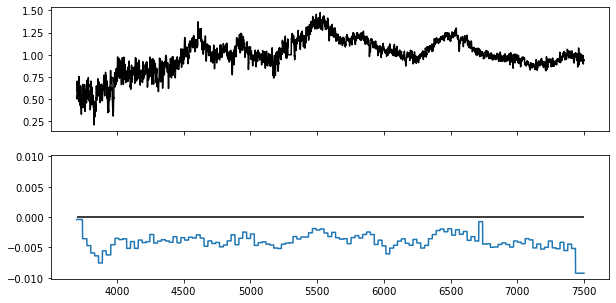

In [34]:
# config file
score_config = {
    "metric": "lp",
    "velocity": 250,
# if reconstruction
    "relative": False,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
# segmentation: [uniform, kmeans]
# with kmeans it is a good idea to put a large number
# of segments in order to let it find a more suitable
# configuration
    "segmentation": "uniform",
    "number_segments": 128,
    "number_samples": 2000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians
    "kind_of_fudge": "flat",
# flat
    "continuum": 1,
# gaussians
    "amplitude":2.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": False,
    "kernel_size": 3,
    "sigma": 1
}
# Load notebook with anomalies
anomaly_from_score = "lp_filter_250kms_noRel97"
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
# meta.get_sky_server_url(anomalies_df.index[-4])
# plt.plot(wave, galaxy)
specobjid = anomalies_df.index[-14]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0)
meta.get_sky_server_url(specobjid)

Set explainer and Get explanations
Get heat map of explanation


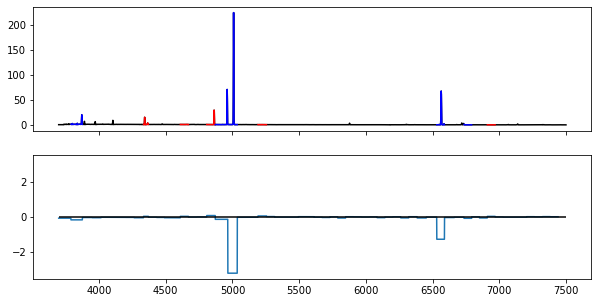

In [46]:
# config file
score_configuration = {
    "metric": "mse",
    "velocity": 0,
# if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": [
        "OII_3726",
        "H_delta_4101",
        "H_gamma_4340",
        "H_beta_4861",
        "OIII_4959",
        "OIII_5006",
        "NII_6548",
        "H_alpha_6562",
        "NII_6583",
        "SII_6716",
        "SII_6730"
    ]
}
lime_configuration = {
# segmentation: [uniform, kmeans]
# with kmeans it is a good idea to put a large number
# of segments in order to let it find a more suitable
# configuration
    "segmentation": "kmeans",
    "number_segments": 64,
    "number_samples": 1000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_configuration = {
# same, same_shape, flat, with_mean, gaussians
    "kind_of_fudge": "flat",
# flat
    "continuum": 1,
# gaussians
    "amplitude":1,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 5
}
# Load notebook with anomalies
anomaly_from_score = "mse_filter_250kms_noRel100"
anomalies_df = pd.read_csv(f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
# meta.get_sky_server_url(anomalies_df.index[-4])
# plt.plot(wave, galaxy)
idx_spectrum = specobjid_to_idx(anomalies_df.index[-12], idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_score(wave, spectrum,
    score_configuration, lime_configuration, fudge_configuration,
    model
)

fig, axs = interpret(None, None, wave, pkl=False, explanation=explanation, npos=5, nneg=5)